<a href="https://colab.research.google.com/github/mavillot/FUNSD-Information-Extraction/blob/main/Detection/IceVision/FasterRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FasterRCNN

In this Notebook we'll be using a FasterRCNN model to detect different block texts. We'll use IceVision, an Agnostic Object Detection Framework.

The first thing we need to do is to install the libraries.

## Libraries

### Fastai

In [1]:
%%capture
!pip install fastai --upgrade

In [2]:
from fastai.vision.all import *

### IceVision

In [3]:
%%capture
!pip install icevision[all]==0.5.1
!pip install torchtext==0.8.1

In [ ]:
from icevision.all import *

### Google Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset

Once we are done with the installation, we load the [FUNSD dataset](https://guillaumejaume.github.io/FUNSD/). This dataset is a dataset for Text Detection, Optical Character Recognition, Spatial Layout Analysis and Form Understanding. It's made up of 199 fully annotated forms.

In [ ]:
%%capture
!wget https://guillaumejaume.github.io/FUNSD/dataset.zip -O dataset.zip
!unzip dataset.zip

Let's see the structure of this dataset:

In [ ]:
path=Path('dataset')

In [ ]:
path.ls()

(#3) [Path('dataset/testing_data'),Path('dataset/.DS_Store'),Path('dataset/training_data')]

In [ ]:
path_train=path/'training_data'
path_test=path/'testing_data'

In [ ]:
path_train.ls()

(#3) [Path('dataset/training_data/.DS_Store'),Path('dataset/training_data/annotations'),Path('dataset/training_data/images')]

In [ ]:
path_train_img=path_train/'images'
path_train_anot=path_train/'annotations'

In [ ]:
path_train_img.ls()

(#149) [Path('dataset/training_data/images/81310636.png'),Path('dataset/training_data/images/93213298.png'),Path('dataset/training_data/images/0060308251.png'),Path('dataset/training_data/images/0013255595.png'),Path('dataset/training_data/images/91391310.png'),Path('dataset/training_data/images/71601299.png'),Path('dataset/training_data/images/00283813.png'),Path('dataset/training_data/images/0060262650.png'),Path('dataset/training_data/images/92327794.png'),Path('dataset/training_data/images/01073843.png')...]

In [ ]:
path_train_anot.ls()

(#149) [Path('dataset/training_data/annotations/0001123541.json'),Path('dataset/training_data/annotations/00922237.json'),Path('dataset/training_data/annotations/0060136394.json'),Path('dataset/training_data/annotations/93455715.json'),Path('dataset/training_data/annotations/93351929_93351931.json'),Path('dataset/training_data/annotations/0000999294.json'),Path('dataset/training_data/annotations/71206427.json'),Path('dataset/training_data/annotations/0001463282.json'),Path('dataset/training_data/annotations/0071032790.json'),Path('dataset/training_data/annotations/91856041_6049.json')...]

In [ ]:
path_test_img=path_test/'images'
path_test_anot=path_test/'annotations'

## Icevision

In order to create and evaluate an IceVision's model, we need to follow the next steps:

1. Create a parser to read the images and annotations
2. Construct the record objects from the parser
3. Define the transforms
4. Create the datasets from the records and augmentations
5. Create the dataloaders from the datasets
6. Define the model
7. Train the model
8. Save the model
9. Inference 






### 1. Parser

In [ ]:
class AnotacionParser(parsers.Parser, parsers.FilepathMixin, parsers.LabelsMixin, parsers.BBoxesMixin):
    pass

IceVision provides a method: `generate_template` which gives us the methods we need to implement in out parser.


In [ ]:
AnotacionParser.generate_template()

def __iter__(self) -> Any:
def imageid(self, o) -> Hashable:
def image_width_height(self, o) -> Tuple[int, int]:
    return get_image_size(self.filepath(o))
def filepath(self, o) -> Union[str, Path]:
def bboxes(self, o) -> List[BBox]:
def labels(self, o) -> List[int]:


Implementation:

In [ ]:
import os
import re

In [ ]:
class AnotacionParser(parsers.Parser, parsers.FilepathMixin, parsers.LabelsMixin, parsers.BBoxesMixin):
    def __init__(self, path_img,path_anotaciones,d):
        self.path_img = path_img
        self.path_anotaciones= path_anotaciones
        self.class_map=d

    def __iter__(self):
      with os.scandir(self.path_anotaciones) as ficheros:
        for fichero in ficheros:
          yield fichero.name

    def imageid(self, o) -> Hashable: #o --> nombre de la anotación
      return o[:o.find('.')]

    def filepath(self, o) -> Union[str, Path]:
      path=Path(f"{o[:o.find('.')]}.png")
      return self.path_img / path

    def image_width_height(self, o) -> Tuple[int, int]:
      return get_image_size(self.path_img+'/'+f"{o[:o.find('.')]}.png")

    def labels(self, o) -> List[int]:
      path=self.path_anotaciones+'/'+o
      anotacion=json.loads(open(path).read())
      label=[]
      for form in anotacion:
        for j in anotacion[form]:
          label.append(self.class_map.get_name(j['label']))
      return label

    def bboxes(self, o) -> List[BBox]:
      path=self.path_anotaciones+'/'+o
      anotacion=json.loads(open(path).read())
      bbox=[]
      for i in anotacion:
        for j in anotacion[i]: # recorre anotacion['form']
          bbox.append(BBox.from_xyxy(j['box'][0],j['box'][1],j['box'][2],j['box'][3]))
      return bbox

We define now the `class_map` which is just an object from the `ClassMap` Class. It contains all the classes of our dataset.

In [ ]:
class_map=ClassMap(['question', 'answer', 'header', 'other'])

We define the parser for the training and testing set. 

In [ ]:
path

Path('dataset')

In [ ]:
parser = AnotacionParser(str(path_train_img), str(path_train_anot),class_map)

In [ ]:
parser_test = AnotacionParser(str(path_test_img), str(path_test_anot),class_map)

### 2. Records


In [ ]:
train_records, valid_records= parser.parse(RandomSplitter((0.8, 0.2)))

INFO     - Autofixing records | icevision.parsers.parser:parse:126


In [ ]:
test_records=parser_test.parse(RandomSplitter((1, 0)))

INFO     - Autofixing records | icevision.parsers.parser:parse:126


### 3. Transforms

The transforms and augmentations are an important part in the construction of the computer visions' models. IceVision includes a library [Albumentations](https://github.com/albumentations-team/albumentations) which provide us a different transformations.

We won't be using any flipping or rotating transformation because of the nature of our dataset. It doesn't make sense to flip or rotate a form, so we'll just normalize the images.


In [ ]:
presize = 1000
size = 800

In [ ]:
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size), tfms.A.Normalize()])
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize,shift_scale_rotate=None,crop_fn=None, horizontal_flip=None, pad=None), tfms.A.Normalize()])

### 4. Dataset

The `Dataset` class is used to combine the records and the tranformations. We will create a dataset for our training set, validation set and testing test.


In [ ]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)
test_ds = Dataset(test_records, valid_tfms) 

Once we have created all the datasets we can show the images that take part in these datasets. This will help us to visualize and check the transformations we made to the original images.


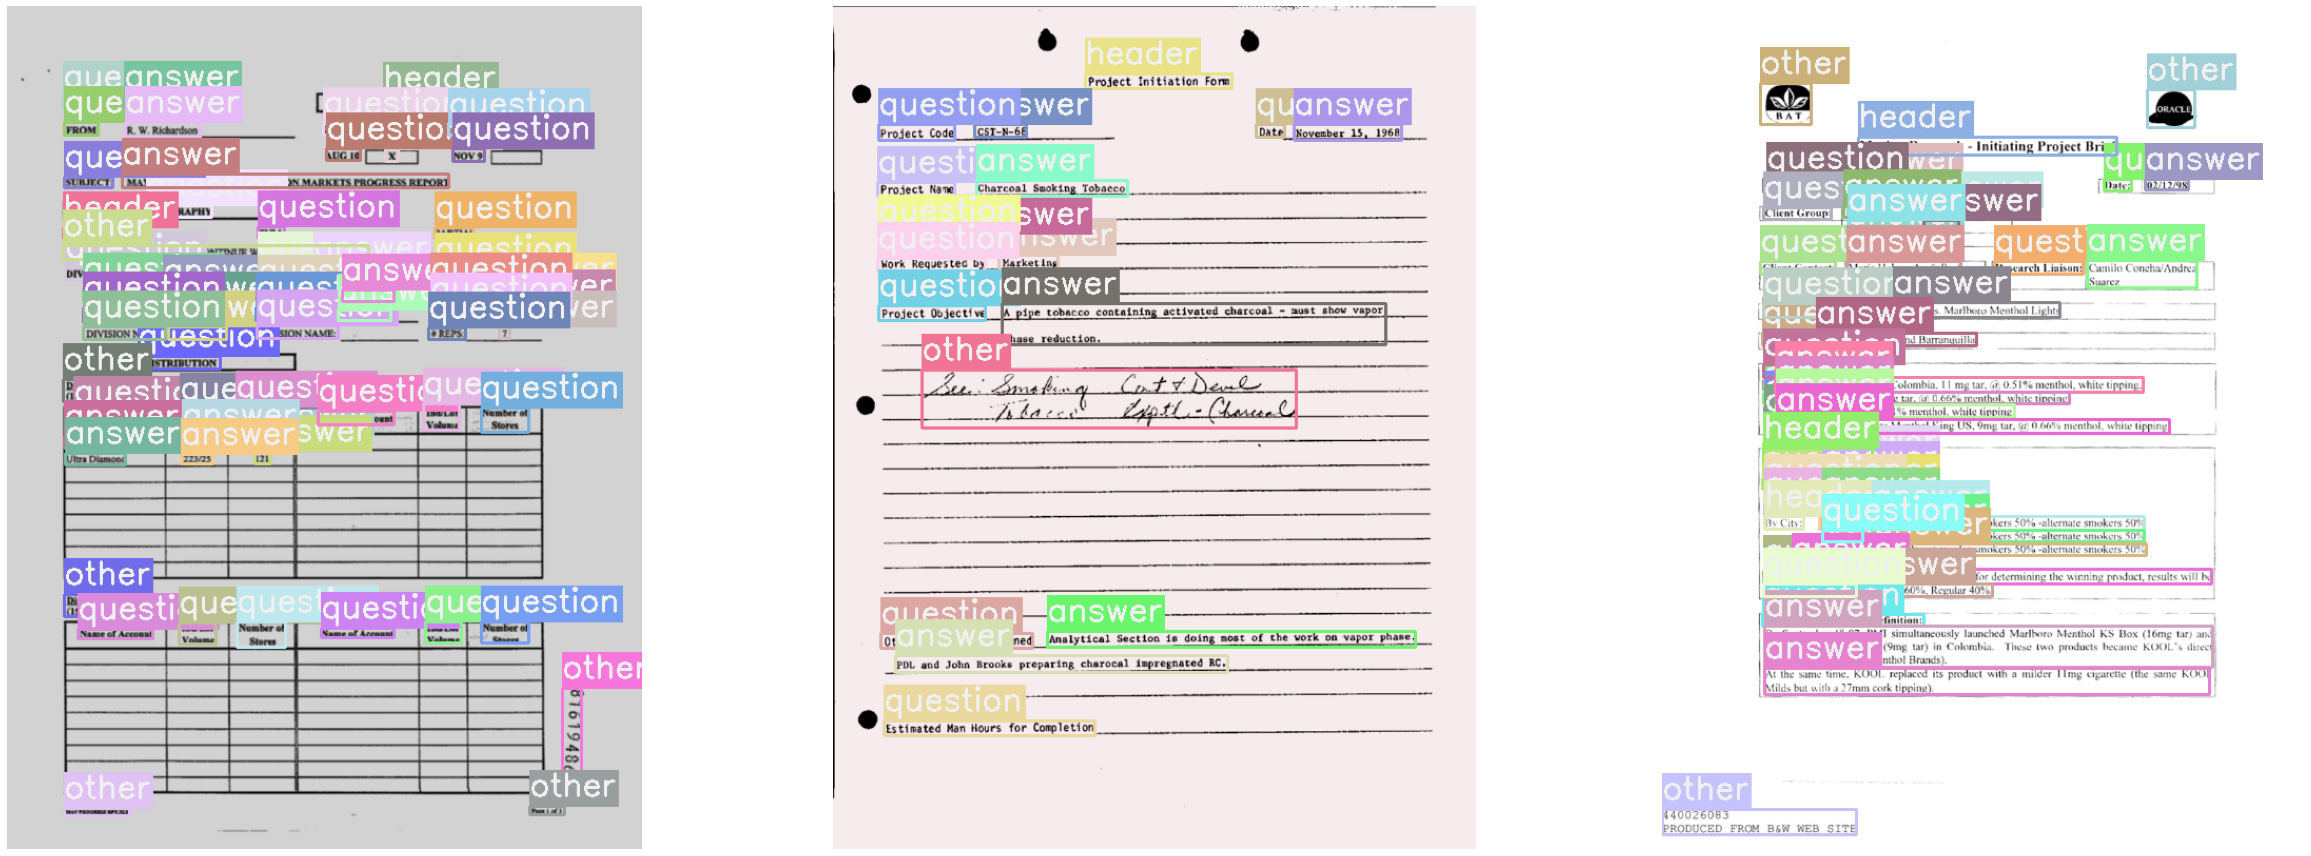

In [ ]:
samples = [train_ds[i] for i in range(3)]
show_samples(samples, ncols=3, class_map=class_map,denormalize_fn=denormalize_imagenet)

### 5. DataLoaders

In [ ]:
train_dl = faster_rcnn.train_dl(train_ds, batch_size=8, num_workers=0, shuffle=True)
valid_dl = faster_rcnn.valid_dl(valid_ds, batch_size=8, num_workers=0, shuffle=False)
test_dl = faster_rcnn.valid_dl(test_ds, batch_size=8, num_workers=0, shuffle=False)

### 6. The model

In order to create and train our model we need to create a `Learner` object from FastAI. 
The first thing we need to do is to build the model with the architecture that we want, in this case Faster RCNN.

We load a model we had train before.

In [ ]:
model = faster_rcnn.model(num_classes=len(class_map))

The next thing we need to do is to define the metrics, the callbacks and the Learner:

In [ ]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [ ]:
callbacks = [EarlyStoppingCallback(patience=3),SaveModelCallback(fname='modelFasterRCNN'),ReduceLROnPlateau(patience=2) ]

In [ ]:
learn = faster_rcnn.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics,cbs=callbacks)

### 7. Training

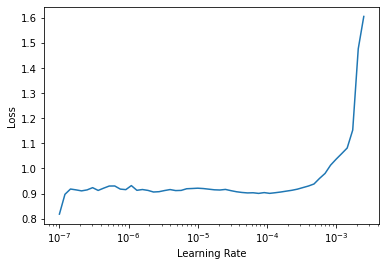

In [ ]:
(min_lr,step)=learn.lr_find(show_plot=True)

In [ ]:
learn.fine_tune(50,min_lr,freeze_epochs=2)

epoch,train_loss,valid_loss,COCOMetric,time
0,8.789515,8.090599,0.001786,00:24
1,8.510948,8.077595,0.006826,00:20


Better model found at epoch 0 with valid_loss value: 8.090599060058594.
Better model found at epoch 1 with valid_loss value: 8.077594757080078.


epoch,train_loss,valid_loss,COCOMetric,time
0,4.656347,2.196454,0.023947,00:35
1,3.069133,1.843031,0.033560,00:33
2,2.502761,1.612853,0.043518,00:33
3,2.143582,1.453163,0.070931,00:33
4,1.903283,1.413412,0.099842,00:33
5,1.731144,1.369919,0.113964,00:33
6,1.604200,1.307980,0.135552,00:33
7,1.499920,1.264265,0.155272,00:33
8,1.414513,1.255792,0.164551,00:33
9,1.345047,1.241502,0.181260,00:33


Better model found at epoch 0 with valid_loss value: 2.1964540481567383.
Better model found at epoch 1 with valid_loss value: 1.8430311679840088.
Better model found at epoch 2 with valid_loss value: 1.6128530502319336.
Better model found at epoch 3 with valid_loss value: 1.4531633853912354.
Better model found at epoch 4 with valid_loss value: 1.413412094116211.
Better model found at epoch 5 with valid_loss value: 1.3699188232421875.
Better model found at epoch 6 with valid_loss value: 1.3079800605773926.
Better model found at epoch 7 with valid_loss value: 1.2642652988433838.
Better model found at epoch 8 with valid_loss value: 1.2557923793792725.
Better model found at epoch 9 with valid_loss value: 1.2415015697479248.
Better model found at epoch 10 with valid_loss value: 1.1939254999160767.
Epoch 12: reducing lr to 1.7484223324531398e-05
Better model found at epoch 13 with valid_loss value: 1.192903995513916.
Better model found at epoch 14 with valid_loss value: 1.1726219654083252.
Be

In [ ]:
torch.save(model.state_dict(),'/content/drive/MyDrive/ICEVISION/FasterRCNN/modelFasterRCNN_23.pth')

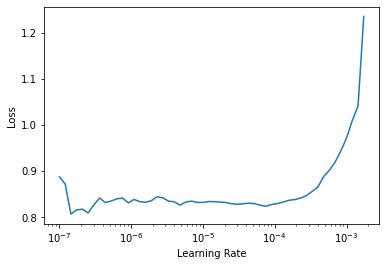

In [ ]:
(min_lr,step)=learn.lr_find(show_plot=True)

In [ ]:
learn.fine_tune(50,step,freeze_epochs=2)

epoch,train_loss,valid_loss,COCOMetric,time
0,0.919679,0.931843,0.339056,00:54
1,0.923533,0.923530,0.342263,00:40


Better model found at epoch 0 with valid_loss value: 0.9318430423736572.
Better model found at epoch 1 with valid_loss value: 0.9235297441482544.


epoch,train_loss,valid_loss,COCOMetric,time
0,0.914334,0.914126,0.342066,01:16
1,0.914145,0.918149,0.342123,01:08
2,0.913295,0.924680,0.342078,01:08
3,0.914474,0.914115,0.342425,01:07
4,0.915990,0.907551,0.342380,01:07
5,0.913339,0.931236,0.341826,01:07
6,0.911798,0.914151,0.341450,01:08
7,0.910078,0.915205,0.341833,01:08


Better model found at epoch 0 with valid_loss value: 0.9141255021095276.
Epoch 2: reducing lr to 1.4974713576211792e-08
Better model found at epoch 3 with valid_loss value: 0.914115309715271.
Better model found at epoch 4 with valid_loss value: 0.9075511693954468.
Epoch 6: reducing lr to 3.029779554013574e-08
No improvement since epoch 4: early stopping


### 8. Save the model

In [ ]:
torch.save(model.state_dict(),'/content/drive/MyDrive/ICEVISION/FasterRCNN/modelFasterRCNN_34.pth')

### 9. Inference

We are going to use the model to predict new images.

We load a better model we had trained before:

In [ ]:
model = faster_rcnn.model(num_classes=len(class_map))
state_dict = torch.load('/content/drive/MyDrive/ICEVISION/modelFasterRCNN_36.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
from tqdm import tqdm, trange
import time

We save the predictions in order to evaluate them.

In [ ]:
test= path_test_img.ls()
i=0
test_img=[cv2.imread(str(test[i]))]
for f in test:
  txt=open('/content/drive/MyDrive/ICEVISION/FasterRCNN/prediccionesFasterRCNN/'+str(f.stem)+'.txt','w')
  test_img=[cv2.imread(str(f))]
  clone=cv2.imread(str(f))
  Y,X,_=clone.shape
  infer_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size),tfms.A.Normalize()])
  infer_ds = Dataset.from_images(test_img, infer_tfms)
  batch, samples = faster_rcnn.build_infer_batch(infer_ds)
  preds = faster_rcnn.predict(model=model, batch=batch,detection_threshold=0.5) 
  labels=preds[0]['labels'] 
  bbox=preds[0]['bboxes']
  for i in tqdm(range(len(labels))):
    x1=bbox[i].xmin-(samples[0]['img'].shape[1]-samples[0]['width'])/2
    y1=bbox[i].ymin
    z1=bbox[i].xmax-(samples[0]['img'].shape[1]-samples[0]['width'])/2
    w1=bbox[i].ymax

    x1=X*x1/samples[0]['width']
    y1=Y*y1/samples[0]['height']
    z1=X*z1/samples[0]['width']
    w1=Y*w1/samples[0]['height']
    txt.write(str(labels[i])+' '+ str(x1)+' '+ str(y1)+' '+ str(z1)+' '+ str(w1)+'\n')

100%|██████████| 35/35 [00:02<00:00, 13.41it/s]


In [6]:
import shutil
shutil.make_archive('/content/drive/MyDrive/ICEVISION/FasterRCNN/prediccionesFasterRCNN', 'zip', '/content/drive/MyDrive/ICEVISION/FasterRCNN/prediccionesFasterRCNN')

'/content/drive/MyDrive/ICEVISION/FasterRCNN/prediccionesFasterRCNN.zip'

We show a prediction:

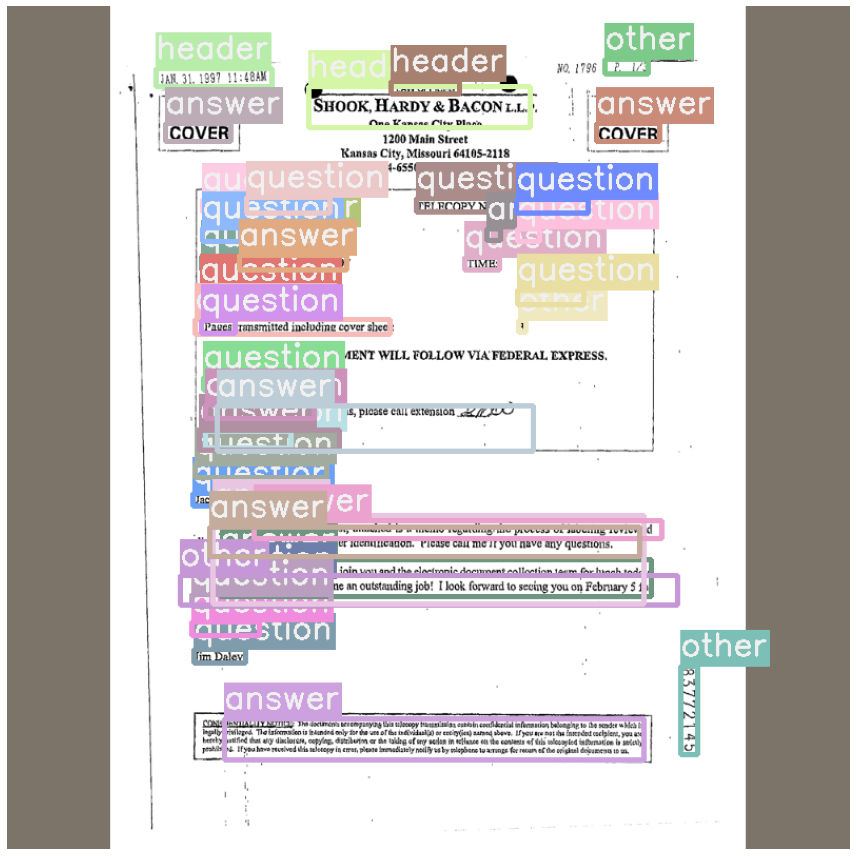

In [ ]:
imgs = [sample["img"] for sample in samples]
show_preds(
    samples=imgs,
    preds=preds,
    class_map=class_map,
    denormalize_fn=denormalize_imagenet,
    show=True,
)